# 밑바닥부터 시작하는 딥러닝

# Deep Learning from Scratch

# 6 학습 관련 기술들

가중치 매개변수의 최적값을 탐색하는 최적화 방법. 가중치 매개변수 초기값, 하이퍼파라미터 설정 방법

오버피팅 대응책인 가중치 감소, 드롭아웃

배치 정규화

## 6.1 매개변수 갱신

최적화 : 손실 함수의 값을 가능한 낮추는 매개변수를 찾음. 최적 매개변수를 찾는 문제를 푸는 것.

확률적 경사 하강법(SGD) : 매개변수 기울기를 구해 기울어진 방향으로 매개변수 값을 갱신하여 점점 최적의 매개변수로 다가가는 방법(미니배치)

### 6.1.1 모험가 이야기

SGD의 전략: 지금 서있는 장소에서 가장 크게 기울어진 방향으로 가는 것.

### 6.1.2 확률적 경사 하강법(SGD)

#### 식 6.1 SGD
\begin{equation*}
W \leftarrow W - \eta \frac{\partial L}{\partial W}
\end{equation*}

\begin{equation*}
W : 갱신할 매개변수
\end{equation*}
\begin{equation*}
\frac{\partial L}{\partial W} : 손실 함수의 기울기
\end{equation*}
\begin{equation*}
\eta : 학습률, 미리 정해서 사용, 0.01 or 0.001 등
\end{equation*}

<- 우변의 값으로 좌변의 값을 갱신

SGD 파이썬 클래스 구현

In [82]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

lr : 학습률, learning rate. 인스턴스 변수로 유지

update(params, grads) : SGD 과정에서 반복해서 호출됨

params : 딕셔너리 변수. 가중치 매개변수 저장됨. 예시 params['W1']

grads : 딕셔너리 변수. 기울기가 저장됨. 예시 grads['W1']

신경망 매개변수 진행 의사코드

```python
network = TwoLayerNet(...)
optimizer = SGD() ###
for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch(...) # 미니배치
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads) ###
    ...
```

optimizer : 변수. 뜻은 최적화를 행하는 자 (하이퍼파리미터)

매개변수 갱신은 optimizer가 책임지고 수행. optimizer에 매개변수와 기울기 정보만 넘기면 됨

최적화를 담당하는 클래스를 분리 구현하면 기능을 모듈화하기 좋음

모멘텀 최적화 기법 역시 update(params, grads)라는 공통의 메서드를 갖도록 구현

optimizer = SGD() 문장을 optimizer = Momentum()으로만 변경하면 됨

Lasagne 딥러닝 프레임워크는 최적화 기법을 다음 함수들로 정리함

https://github.com/Lasagne/Lasagne/blob/master/lasagne/updates.py

### 6.1.3 SGD의 단점

#### 식 6.2 SGD

다음 함수의 최솟값을 구하는 문제 예시

\begin{equation*}
f(x,y) = \frac{1}{20} x^2 + y^2
\end{equation*}

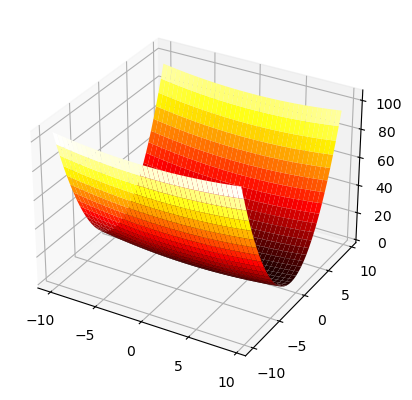

In [83]:
# 그림 6-1 f(x, y) = (1/20) * x**2 + y**2 그래프
# 3차원 참고주소: https://www.datascienceschool.net/view-notebook/6e71dbff254542d9b0a054a7c98b34ec/
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
X = np.arange(-10, 10, 0.5)
Y = np.arange(-10, 10, 0.5)
XX, YY = np.meshgrid(X, Y)
ZZ = (1 / 20) * XX**2 + YY**2

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(XX, YY, ZZ, rstride=1, cstride=1, cmap='hot');

(-10.0, 10.0)

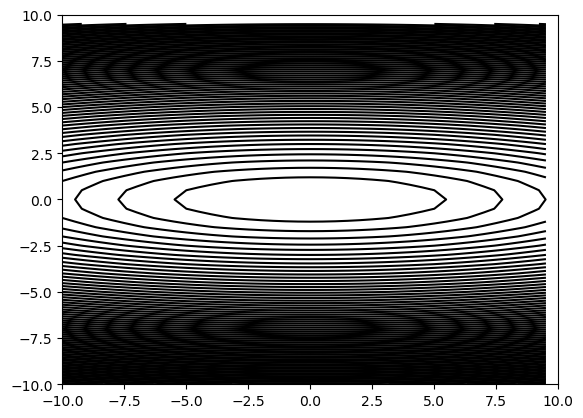

In [84]:
# 그림 6-1 f(x, y) = (1/20) * x**2 + y**2 등고선
plt.contour(XX, YY, ZZ, 100, colors='k')
plt.ylim(-10, 10)
plt.xlim(-10, 10)

In [85]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성

    for idx in range(x.size):
        tmp_val = x[idx]

        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)

        # f(x-h) 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원

    return grad

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


f(x,y) = 1/20*x**2 + y**2 의 기울기


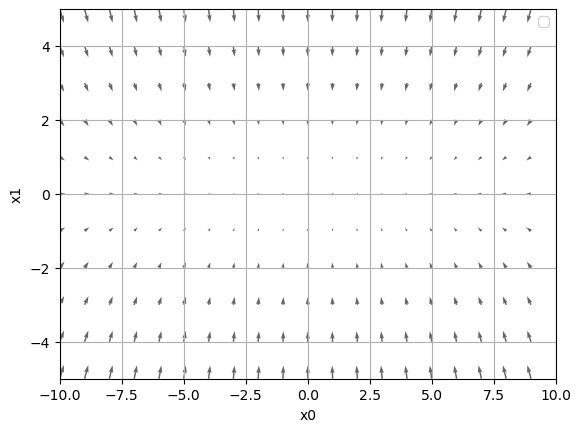

In [86]:
# 그림 6-2 f(x, y) = (1/20) * x**2 + y**2 의 기울기
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch04/gradient_2d.py 소스 참고
from mpl_toolkits.mplot3d import Axes3D

def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)

        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)

        return grad

def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)

x0 = np.arange(-10, 10, 1)
x1 = np.arange(-10, 10, 1)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([(1/(20**0.5))*X, Y]) )


print('f(x,y) = 1/20*x**2 + y**2 의 기울기')
plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
plt.xlim([-10, 10])
plt.ylim([-5, 5])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.legend()
plt.draw()
plt.show()

위 함수의 기울기는 아래와 같음. 이 기울기는 y축 방향은 크고 x축 방향은 작다는 것이 특징임

y축 방향은 가파른데 x축 방향은 완만함 (미분을 하면 1/10x+2y)

식에서는 최소값이 되는 장소는 0,0 이지만 그림에서 보여주는 기울기 대부분은 0,0을 가리키지 않는다

6-1의 함수에 SGD 적용, 초기값은 (-7.0, 2.0)

지난 번 학습시 x**2+y**2은 일직선을 줄어들었다

![](./img/02.png)

SGD 단점 : 비등방성(anisotropy) 함수(방향에 따라 기울기가 달라지는 함수)에서 <u>탐색경로가 비효율적.</u>

SGD의 단점을 개선해주는 모멘텀, AdaGrad,Adam을 학습

### 6.1.4 모멘텀

모멘텀: Momentum, 운동량

![](./img/12.png)

#### 식 6.3
\begin{equation*}
v \leftarrow \alpha v - \eta \frac{\partial{L}}{\partial{W}}
\end{equation*}

#### 식 6.4
\begin{equation*}
W \leftarrow W + v
\end{equation*}

\begin{equation*}
W : 갱신할 매개변수
\end{equation*}
\begin{equation*}
\frac{\partial L}{\partial W} : 손실 함수의 기울기
\end{equation*}
\begin{equation*}
\eta : 학습률, 미리 정해서 사용
\end{equation*}

v : 물리에서 말하는 속도(velocity), 이전까지의 기울기를 반영한 항으로 같은 방향의 경우 가속도 역할을 한다.

알파 : 물체가 아무런 힘을 받지 않을때 서서히 감속시키는 저항역 (0.9등으로 설정해서 이전 기울기가 반영된 값을 줄여준다)

alpha v(알파 * v) : 물체가 아무런 힘을 받지 않을 때 서서히 하강시키는 역할

식 6.3 : 기울기 방향으로 힘을 받아 물체가 가속된다는 물리 법칙을 나타냄

식 6.4 : 모멘텀에 따라 공이 그릇의 바닥을 구르는 듯한 움직임을 보임

모멘텀의 구현

In [87]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

v: 물체의 속도

v는 초기화 때는 아무것도 담지 않고, update가 처음 호출될 때 같은 구조의 데이터를 딕셔너리 변수로 저장

![](./img/03.png)

모멘텀의 갱신 경로는 공이 그릇 바닥을 구르듯 움직임. SGD와 비교하면 지그재그 정도가 덜함

y방향으로는 기울기가 양수방향과 음수방향이 바뀌지만 x방향은 0,0을 향해 일정하게 가속된다. 같은 방향으로 갈때는 가속도로 움직이고, 반대 방향으로 가서 들쑥날쑥할거 같으면 이전의 방향으로 기억해서 조금만 움직여서 들쑥날쑥하지 않게 한다.

### 6.1.5 AdaGrad

학습률이 작으면 학습시간이 너무 길어지고 반대로 너무 크면 발산하여 학습이 제대로 안됨

AdaGrad는 처음에는 크게 학습하다가 조금씩 작게 학습하는 식으로 진행하는 학습률 조정 알고리즘이다.

학습률 감소(learning rate decay) : 학습을 진행하면서 학습률을 점차 줄여가는 방법

개별 매개변수에 적응적으로(adative) 학습률을 조정하면서 학습을 진행

#### 식 6.5
\begin{equation*}
h \leftarrow h + \frac{\partial{L}}{\partial{W}} \odot \frac{\partial{L}}{\partial{W}}
\end{equation*}
\begin{equation*}
\odot : 행렬의 원소별 곱
\end{equation*}

기울기를 제곱해서 더해주면 계속해서 양수의 값을 받아 커지게 된다. 이 값을 아래  1/sqrt(h)를 곱해주면 학습률이 점점 줄어들게 된다.

#### 식 6.6
\begin{equation*}
W \leftarrow W - \eta \frac{1}{\sqrt{h}} \frac{\partial{L}}{\partial{W}}
\end{equation*}

\begin{equation*}
W : 갱신할 매개변수
\end{equation*}
\begin{equation*}
\frac{\partial L}{\partial W} : 손실 함수의 기울기
\end{equation*}
\begin{equation*}
\eta : 학습률, 미리 정해서 사용
\end{equation*}

h : 기존 기울기 값을 제곱하여 계속 더해줌

매개변수를 갱신할 때 1/sqrt(h)을 곱해 학습률을 조정

매개변수의 원소 중에서 많이 움직인(크게 갱신된) 원소는 학습률이 낮아진다는 뜻. 학슴률의 감소가 매개변수의 원소마다 다르게 적용됨을 뜻

AdaGrad는 학습을 진행할 수록 갱신 강도가 약해짐.

실제로 무한히 계속 학습한다면 어느 순간 갱신량이 0이 되어 전혀 갱신되지 않게 됨

이 문제를 개선하기 위한 기법으로 RMSProp이 있음

**RMSProp **

지수이동평균(Exponential Moving Average, EMA)를 이용하여 먼 과거의 기울기를 서서히 잊고 새로운 기울기 정보를 크게 반영. 과거 기울기의 반영규모를 기하급수적으로 감소시킴

AdaGrad의 구현

In [88]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

마지막 줄에서 1e-7이라는 작은 값을 더하는 부분이 0으로 나누는 사태를 막음

대부분의 딥러닝 프레임워크에서 이 값도 인수로 설정 가능

처음에는 크게 움직이지만 갱신 정도가 작아지도록 조정됨

![](./img/04.png)

최솟값을 향해 효율적으로 움직임. y축 방향은 기울기가 커서 처음에는 크게 움직이지만, 그 큰 움직임에 비례해 갱신정도도 큰 폭으로 작아지도록 조정됨. y축 방향으로 갱신강도가 빠르게 약해지고 지그재그 움직임이 줄어듬

### 6.1.6 Adam

모멘텀: 공이 그릇을 구르는 듯한 물리 법칙에 따르는 움직임

AdaGrad: 매개변수의 원소마다 적응적으로 갱신 정도를 조정

Adam: 모멘텀과 Adagrad 기법을 융합

매개변수 공간을 효율적으로 탐색. 하이터파라미터의 '편향 보정'이 진행됨

![](./img/05.png)

momentum때보다 공의 좌우 흔들림이 작다. 학습의 갱신강도를 적응적으로 조정해서 얻는 혜택

Adam의 구현

In [89]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/common/optimizer.py 참고
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

### 6.1.7 어느 갱신 방법을 이용할 것인가?

네 기법의 결과를 비교

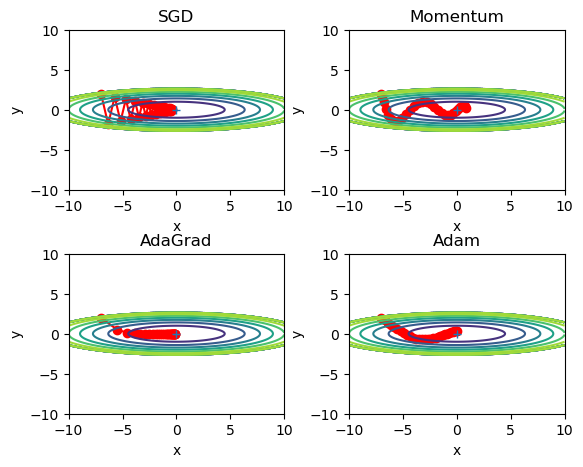

In [90]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/optimizer_compare_naive.py 참고
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
#대상이 되는 함수 정의
def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y): # f의 미분
    return x / 10.0, 2.0*y

# 매개변수와 기울기 초기값
init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

# 옵티마이저 생성
optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

# 수정된 내용: 초기값 설정
idx = 1

#옵티마이저별 탐색
for key in optimizers:
    optimizer = optimizers[key] #옵티마이저 지정
    x_history = []
    y_history = [] # 이동경로
    params['x'], params['y'] = init_pos[0], init_pos[1] #초기위치

    #옵티마이저별로 30번의 매개변수 갱신을 시도함
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)


    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0

    # 그래프 그리기
    plt.subplot(2, 2, idx)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.3, hspace=0.4)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.show()


문제가 무엇이냐에 따라 사용할 기법이 달라짐

하이퍼 파라미터를 어떻게 설정하느냐에 따라서 결과도 바뀜

모든 문제에서 항상 뛰어난 기법은 아직 없음

이 책에서는 SGD, Adam을 많이 사용.

===========iteration:0===========
SGD:2.3518577812995094
Momentum:2.497161784489807
AdaGrad:2.3965621723509916
Adam:2.1996243587094346
===========iteration:100===========
SGD:1.3883724291305732
Momentum:0.2876642916118798
AdaGrad:0.09905107457698198
Adam:0.260168542681039
===========iteration:200===========
SGD:0.670565423904386
Momentum:0.24778098869853893
AdaGrad:0.13198912298354987
Adam:0.2285819452627311
===========iteration:300===========
SGD:0.4583374175673293
Momentum:0.22284385459751826
AdaGrad:0.10727548629170458
Adam:0.1518747866814013
===========iteration:400===========
SGD:0.3660975557976203
Momentum:0.17401215782452686
AdaGrad:0.07657804207056021
Adam:0.10821925058495863
===========iteration:500===========
SGD:0.2950706528909419
Momentum:0.12698606036495214
AdaGrad:0.054986572251322315
Adam:0.08397996338182212
===========iteration:600===========
SGD:0.4312609823673141
Momentum:0.20831357790457705
AdaGrad:0.06364047594949912
Adam:0.12616777297735426
===========iteration:700

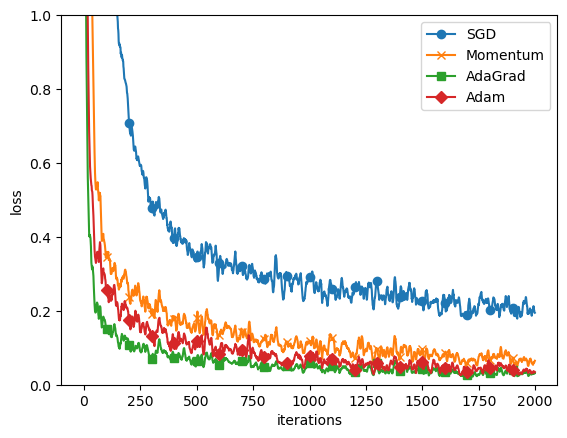

In [91]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/optimizer_compare_mnist.py 참고
# coding: utf-8
#import os
#import sys
#sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
#from common.optimizer import *

# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []

# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

각 층이 100개의 뉴런으로 구성된 5층 신경망에서 ReLU를 활성화 함수로 사용해 측정

하이퍼파라미터인 학습률과 신경망의 구조(층 깊이 등)에 따라 결과가 달라짐

일반적으로 SGD보다 다른 세 기법이 빠르게 학습하고, 때로는 최종 정확도도 높음


- SGD
  - 단점: 전체 데이터에 대해서 계산을 하다보니 시간이 너무 오래 걸린다.
  - 장점: 구현이 쉽다.

- Momentum
  - 단점: 지역 최적점에 빠질 가능성이 있다.
  - 장점: 이전 기울기를 참고하여 이동하므로, SGD보다 빠르게 수렴할 수 있다.

- AdaGrad
  - 단점: 학습률이 너무 작아져서 학습이 느려질 수 있다.(이동이 느려진다)
  - 장점: 학습률을 적절하게 조절해준다.

- Adam
  - 단점: 하이퍼파라미터가 많아 튜닝이 어렵다.
  - 장점: Momentum과 AdaGrad를 융합한 방법으로, 각 하이퍼파라미터들이 자동으로 조절되기 때문에 하이퍼파라미터 튜닝이 어느정도 자동으로 이루어진다.

![](./img/13.png)

## 6.2 가중치의 초기값

가중치의 초기값을 무엇으로 설정하느냐가 신경망 학습의 성패를 가름

### 6.2.1 초기값을 0으로 하면?

가중치 감소(weight decay) : 오버피팅을 억제해 범용 성능을 높이는 테크닉

* 가중치 매개변수 값이 작아지도록 학습하는 방법.
* 가중치 값을 작게 하여 오버피팅이 일어나지 않음.

초기가중치값을 작게 하기 위해 0.01 * np.random.randn(10,100) 처럼 정규분포로 생성된 값에 0.01을 곱함

초기값을 모두 0으로 해서는 안되는 이유?

오차역전법에서 모든 가중치의 값이 똑같이 갱신되기 때문

* 순전파: 입력파의 가중치가 0이기 때문에 두 번째 층의 뉴런에 모두 같은 값이 전달
* 역전파: 가중치가 모두 똑같이 갱신

가중치를 여러개 갖는 의미를 사라지게 함.
가중치가 고르게 되어버리는 상황을 막으려면 초깃값을 무작위로 설정해야 함

### 6.2.2 은닉층의 활성화값 분포

가중치의 초기값에 따라 은닉층 활성화 값들이 어떻게 변화는지 실험

각 층의 활성화값 분포를 히스토그램으로 그림

In [92]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/weight_init_activation_histogram.py 참고
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

def get_activation(hidden_layer_size, x, w, a_func=sigmoid):
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]

        a = np.dot(x, w)

        # 활성화 함수도 바꿔가며 실험해보자！
        z = a_func(a)
        # z = ReLU(a)
        # z = tanh(a)

        activations[i] = z
    return activations

# 초깃값을 다양하게 바꿔가며 실험해보자！
w = np.random.randn(node_num, node_num) * 1
# w = np.random.randn(node_num, node_num) * 0.01
# w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
# w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

z = sigmoid
# z = ReLU
# z = tanh

activations = get_activation(hidden_layer_size, x, w, z)

case1.1 표준 정규 분포에 따르는 가중치 초기값은 0을 중심으로 -3~3으로 시그모이드 함수 통과 후 데이터가 0과 1사이에 치우쳐 분포하게 되며 역전파의 기울기 값이 점점 작아지다 사라진다.

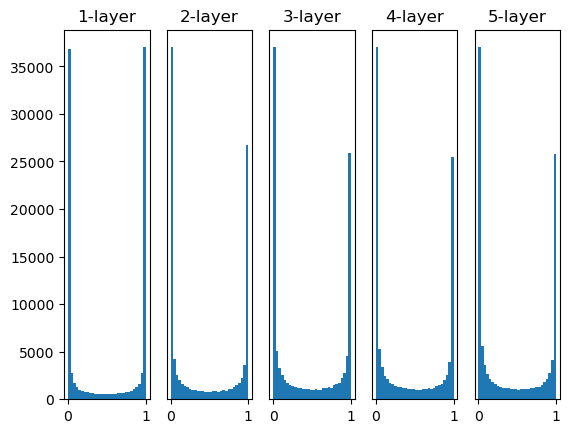

In [93]:
# 히스토그램 그리기
def get_histogram(activations):
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        # plt.xlim(0.1, 1)
        # plt.ylim(0, 7000)
        plt.hist(a.flatten(), 30, range=(0,1))
    plt.show()

get_histogram(activations)

기울기 소실(gradient vanishing)

데이터가 0과 1에 치우쳐 분포하게 되면 역전파 기울기 값이 점점 작아지다 사라짐

기울기가 0이면 학습할때 갱신되는 것이 없다

층을 깁게 하는 딥러닝에서 기울기 소실은 더 심각한 문제가 될 수 있음

가중치의 표준편차를 0.01인 정규분포에 따르는 가중치 초기값은 매우 0에 근접한 값(-0.03~0.03)들이며 그 결과 활성화 값은 0.5 부근에 집중되어 있어 기울기 소실문제는 해결되지만, 모두 유사한 가중치 값을 가지면 뉴런을 많이 만든것이 의미가 없다


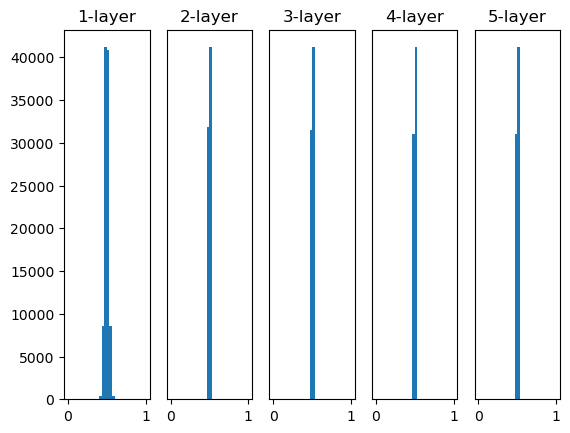

In [94]:
w = np.random.randn(node_num, node_num) * 0.01
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

0.5 부근에 집중. 활성화값들이 치우쳤다는 것은 표현력 관점에서 큰 문제

표현력을 제한: 예를 들어 뉴런 100개가 거의 같은 값을 출력한다면 뉴런 1개짜리와 별반 다를게 없음

활성화 값들이 치우치면 표현력을 제한한다는 관점에서 문제가 됨

<u>case1.3 Xavier 초기값</u>

앞 계층의 노드가 n개라면 표준편차가 1 / sqrt(n)인 정규분포를 사용

1 층에서 적절히 넓게 분포되고, 이후 층이 깊어져도 일정 이상의 분포를 유지

앞 층의 노드 수 외에 다음 출력 노드 수도 고려한 설정 값 제안.

카페 등의 프레임워크는 앞층의 입력 노드만으로 계산하도록 단순화.

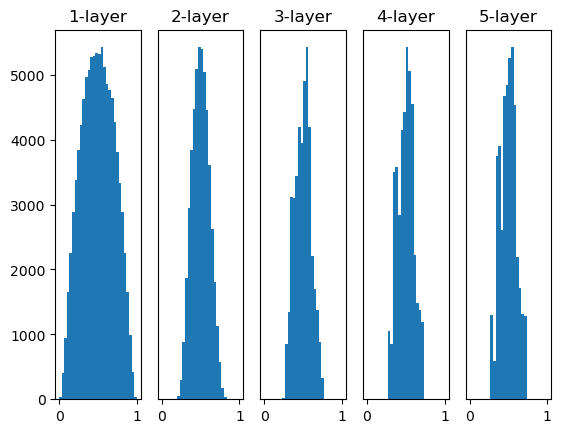

In [95]:
# Xavier 초기값
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

층이 깊어지면서 형태가 다소 일그러지지만, 넓게 분포됨

시그모이드 함수의 표현력도 제한받지 않고 학습이 효율적으로 이뤄질 것

### 6.2.3 ReLU를 사용할 때의 가중치 초기값

Xavier 초깃값은 활성화 함수가 선형인 것을 전제로 이끈 결과

sigmoid, tanh는 좌우 대칭이라 중앙부근이 선형인 함수로 볼수 있어 Xavier 초기값이 적당

ReLU는 음의 영역이 0이라서 Xavier 초기값이 적당하지 않음

He 초기값 : ReLu에 특화된 초기값.

앞 계층의 노드가 n일 때 표준편차가 sqrt (2 / n)인 정규분포를 사용

Xavier 초깃값이 sqrt(1 / n)인 것과 비교하면 2배 큰 값. ReLU는 음의 영역이 0이라서 더 넓게 분포시키기 위해 2배의 계수가 필요하다고 설명

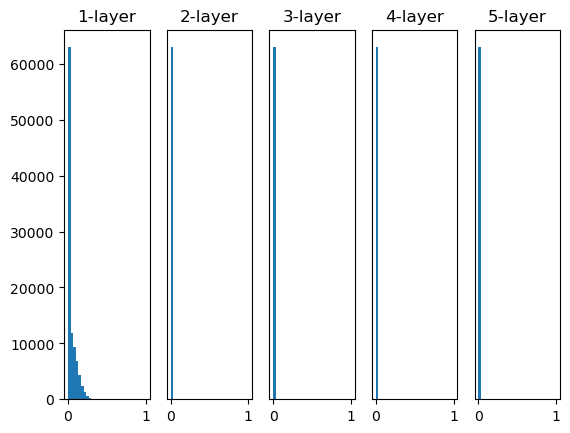

In [96]:
# Relu를 사용한 경우 표준편차가 0.01인 정규분포를 가중치 초기값으로 사용한 경우
w = np.random.randn(node_num, node_num) * 0.01
z = ReLU
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

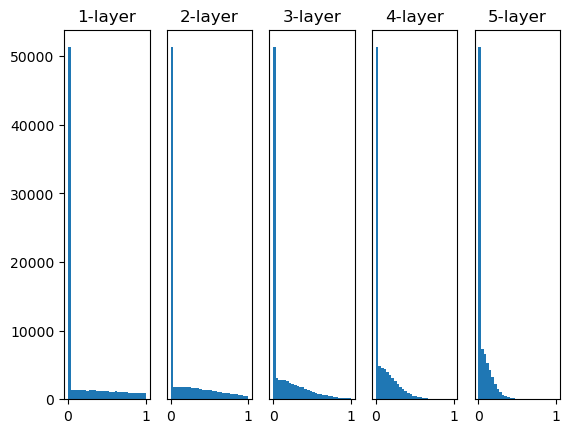

In [97]:
# Xavier 초기값을 사용한 경우
w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

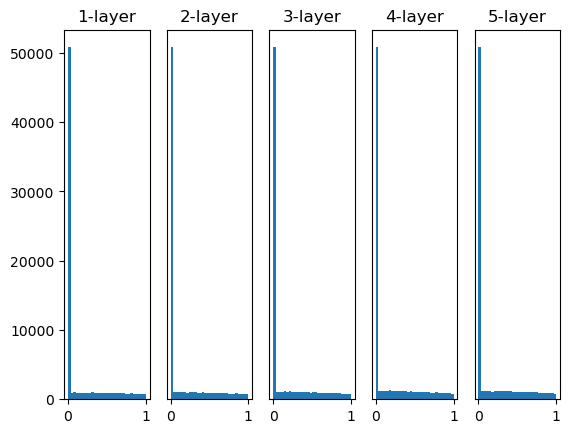

In [98]:
# He 초기값을 사용한 경우
w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
activations = get_activation(hidden_layer_size, x, w, z)
get_histogram(activations)

std = 0.01일 때

각 층의 활성화 값들이 아주 작은 값들. 역전파의 가중치의 기울기 역시 작아짐. 실제로 학습이 거의 이뤄지지 않음. 기울기 소실

Xavier 초기값일 때

층이 깊어지면 활성화값들이 치우침. 학습할 때 '기울기 소실'문제.

He 초기값일 때

모든 층에서 균일하게 분포. Relu 함수는 음수에서 0이 되므로 나머지를 넓게 사용하기 위해 Xavier 입력값이 2배인 He 초기값을 사용

실험결과

활성화 함수로 ReLU를 사용할 때 He 초기값.

활성화 함수로 sigmoid, tanh 등 S자 모양 곡선일 때는 Xavier 초기값.

### 6.2.4 MNIST 데이터셋으로 본 가중치 초기값

실제 데이터로 가중치의 초기값을 주는 방법이 신경망 학습에 얼마나 영향을 주는지 그래프

===========iteration:0===========
std=0.01:2.302516756028052
Xavier:2.305146470454077
He:2.367410630302208
===========iteration:100===========
std=0.01:2.302126227186543
Xavier:2.2623357474033536
He:1.329725929806735
===========iteration:200===========
std=0.01:2.303069302681272
Xavier:2.1861927053565013
He:0.6480671431649849
===========iteration:300===========
std=0.01:2.300938086442435
Xavier:1.99668151387026
He:0.4706634623899728
===========iteration:400===========
std=0.01:2.3003626319231447
Xavier:1.5180240808413938
He:0.3325156664278136
===========iteration:500===========
std=0.01:2.303264234182608
Xavier:1.15868695021776
He:0.4055535093022312
===========iteration:600===========
std=0.01:2.2994558893802703
Xavier:0.7426647054051694
He:0.30884593362469215
===========iteration:700===========
std=0.01:2.301570534799822
Xavier:0.6902393260529889
He:0.39621593411034417
===========iteration:800===========
std=0.01:2.295682378302457
Xavier:0.47196183414254145
He:0.30255271592470645
====

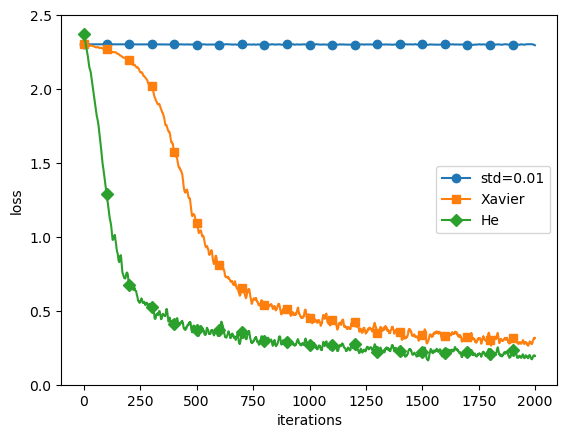

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
#from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

층별 뉴런 수가 100개인 5층 신경망에서 활성화 함수로 ReLu를 사용.

표준편차가 0.01일 때 학습이 전혀 이뤄지지 않음

Xaview, He 초기값은 학습이 순조로움. He 초기값이 학습진도가 빠름.

활성화 함수로 Relu를 사용할 때는 He 초기값을, sigmoid나 tanh 등 S자 모양 곡선일 때는 Xavier 초기값을 쓰는 것이 좋음

## 6.3 배치 정규화

배치 정규화: 가중치의 초기값을 적절히 설정하면 각 층의 활성화 값의 분포가 적당히 퍼지면서 학습이 원활하게 수행된다

각 층이 활서오하 값을 적당히 퍼뜨리도록 강제하는 방법이 배치 정규화

### 6.3.1 배치 정규화 알고리즘

배치 정규화가 주목받는 이유

* 학습을 빨리 진행할 수 있다.
* 초기값에 크게 의존하지 않는다.
* 오버피팅을 억제한다.

배치정규화: 학습시 미니배치를 단위로 정규화

![](./img/07.png)

데이터 분포를 정규화 하는 '배치 정규화' 계층을 신경망에 삽입

데이터 분포가 평균이 0, 분산이 1이 되도록 정규화

#### 식 6.7
\begin{equation*}
\mu_{B} \leftarrow \frac{1}{m} \sum^{m}_{i=1} x_{i}
\end{equation*}
\begin{equation*}
\sigma^{2}_{B} \leftarrow  \frac{1}{m} \sum^{m}_{i=1} (x_{i} - \mu_{B})^{2}
\end{equation*}
\begin{equation*}
x_{i} \leftarrow \frac{x_{i}-\mu_{B}}{\sqrt{\sigma^{2}_{B}+\epsilon}}
\end{equation*}

미니배치 B={x1, x2, ..., xm}

m개의 입력 데이터의 집합에 대해 평균과 분산을 구함.

그 입력 데이터를 평균이 0, 분산이 1이 되게 (적절한 분포가 되게) 정규화

배치 정규화 계층마다 정규화된 데이터에 고유한 확대와 이동 변환을 수행

원래는 편차(시그마)로 나누어 주면 되지만 엡실론을 이용하야 작은값으로 0으로 나누는 사태를 예방

#### 식 6.8
\begin{equation*}
y_{i} = \gamma \hat{x_{i}} + \beta
\end{equation*}

배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대와 이동 변환을 수행

감마가 확대를, 베타기 이동을 담당함. 이 두 값은 처음에는 1, 0으로 (원본 그대로) 학습하면서 적합한 값으로 조정

이 알고리즘이 신경망 순전파때 적용됨

배치 정규화의 계산그래프

![](./img/08.png)

### 6.3.2 배치 정규화의 효과

![](./img/09.png)

배치 정규화가 학습을 빨리 진전시킴. 계속해서 초깃값 분포를 다양하게 줘가며 학습 진행이 어떻게 달라지는지 확인

MNIST 셋을 사용하여 배치 정규화 계층을 사용할 때와 사용하지 않을 때 학습 진도

가중치 초기값의 표준편차를 다양하게 바꿔가며 학습 경과를 관찰한 그래프

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

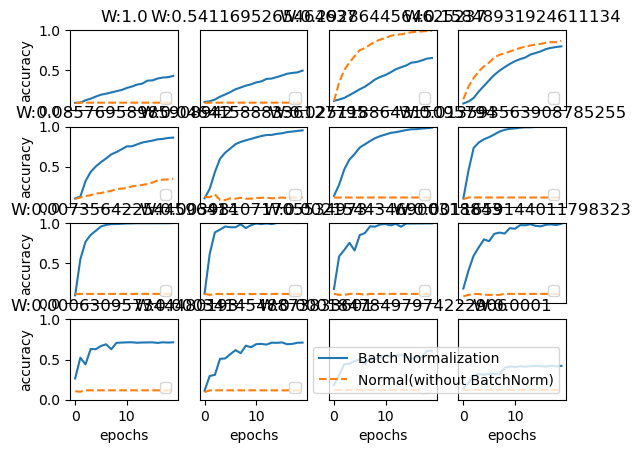

In [100]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/batch_norm_test.py 참고
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
#from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)

    train_acc_list = []
    bn_train_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)

            #print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break

    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    #print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)

    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')

plt.show()

거의 모든 경우에 배치 정규화를 사용할 때 학습 진도가 빠른 것으로 나타남

배치 정규화를 사용하면 학습이 빨라지며, 가중치 초깃값에 크게 의존하지 않아도 됨.

## 6.4 바른 학습을 위해

오버피팅: 신경망의 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에 제대로 대응하지 못하는 상태

### 6.4.1 오버피팅

오버피팅이 발생하는 경우
* 매개변수가 많고 표현력이 높은 모델 (신경망 모델의 표현력은, 해당 모델이 학습 데이터를 얼마나 정확하게 나타낼 수 있는지를 나타내는 지표입니다. 일반적으로, 표현력이 높은 모델은 더 복잡한 함수를 표현할 수 있으므로, 더 정확한 예측 결과를 가져올 수 있습니다. 하지만, 매개변수 수가 많은 모델에서는 이러한 표현력이 오버피팅을 유발하는 가능성을 높일 수 있습니다. 따라서, 표현력과 오버피팅 사이의 균형을 잡는 것이 중요합니다.)
* 훈련 데이터가 적음
* 오버피팅 완화 기법으로는 가중치 감소와 드롭아웃이 있다

이 두 요건을 일부러 충족하여 오버티핑 발생.

훈련 데이터 중 300개만 사용. 7층 네트워크를 사용해 네트워크 복잡성을 높임.

각 층의 뉴런은 100개 활성화 함수는 ReLU를 사용.

In [101]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/overfit_weight_decay.py 참고
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from common.multi_layer_net import MultiLayerNet
#from common.optimizer import SGD

# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
#weight_decay_lambda = 0.1 # weight decay를 사용할 경우
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epoch:0, train acc:0.07666666666666666, test acc:0.1039
epoch:1, train acc:0.09666666666666666, test acc:0.1082
epoch:2, train acc:0.11, test acc:0.1125
epoch:3, train acc:0.11666666666666667, test acc:0.1188
epoch:4, train acc:0.13666666666666666, test acc:0.1263
epoch:5, train acc:0.17333333333333334, test acc:0.1416
epoch:6, train acc:0.19, test acc:0.1588
epoch:7, train acc:0.21666666666666667, test acc:0.1854
epoch:8, train acc:0.26, test acc:0.2021
epoch:9, train acc:0.2866666666666667, test acc:0.2252
epoch:10, train acc:0.3233333333333333, test acc:0.2481
epoch:11, train acc:0.3566666666666667, test acc:0.2744
epoch:12, train acc:0.36666666666666664, test acc:0.2888
epoch:13, train acc:0.39666666666666667, test acc:0.3034
epoch:14, train acc:0.4033333333333333, test acc:0.3131
epoch:15, train acc:0.41333333333333333, test acc:0.3256
epoch:16, train acc:0.43, test acc:0.3331
epoch:17, train acc:0.43333333333333335, test acc:0.3458
epoch:18, train acc:0.47, test acc:0.3606
epoch:

train_acc_list와 test_acc_list에는 에폭단위의 정확도를 저장.

이 두 리스트를 다음처럼 그래프로 그림

case 3.1 오버피팅이 발생하는 MNIST 신경망 구성 구현 코드(300장 데이터 7층망)

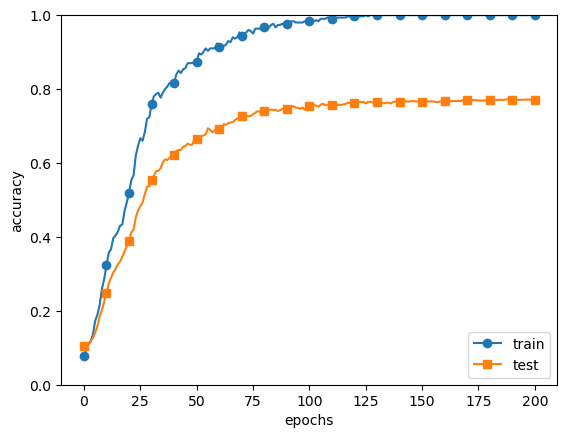

In [103]:
# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

정확도가 크게 벌어지는 것은 훈련 데이터에만 적응(fitting)한 결과

훈련때 사용하지 않은 범용 데이터(시험데이터)에는 제대로 대응하지 못하는 것을 확인

### 6.4.2 가중치 감소

가중치 감소(weight decay)

학습 과정에서 큰 가중치에 대해서는 그에 상응하는 큰 패널티를 부과하여 오버피팅을 억제하는 방법

가중치의 제곱노름을 손실함수에 더하면 가중치가 커지는 것을 억제

신경망 학습의 목적은 손실함수의 값을 줄이는것.

가중치를 W라 하면 L2 노름 법칙에 따른 가중치 감소는 1/2 λ (W**2) 가 되고 이 값을 손실함수에 더함

\begin{equation*}
L =  \sum t_{k} log y_{k} + \frac{1}{2} \lambda W^{2}
\end{equation*}

λ(람다)는 정규화의 세기를 조절하는 하이퍼파라미터. 이 값을 크게 설정할 수록 큰 가중치에 대한 패널티가 커짐

따라서 가중치의 기울기를 구하는 계산에서는 그동안의 오차역전파법에 따른 결과에 정규화 항을 미분한 λW를 더함

1/2 λ (W**2)의 앞쪽 1/2은 1/2 λ (W**2)의 미분결과인 λW를 조정하는 상수의 역할(역전파때 자기 값을 돌려줌)

가중치 감소(Weight decay)는 오버피팅을 방지하기 위한 방법 중 하나로, 손실 함수에 가중치의 크기에 대한 패널티를 추가하여 가중치의 크기가 작아지도록 합니다. 이때, 가중치의 크기 측정 방법으로 사용되는 함수가 L2 노름입니다. L2 노름은 가중치의 제곱합을 계산한 후 그 제곱근을 구하는 방법으로 가중치의 크기를 측정합니다. 수식으로 표현하면 다음과 같습니다. L2 노름 = √(w₁² + w₂² + w₃² + ... + wᵣ²) 여기서 w는 가중치 벡터이며, r은 가중치의 개수를 의미합니다. 가중치 감소에서는 L2 노름에 비례하는 양만큼의 패널티를 손실 함수에 추가함으로써, 가중치의 크기가 작아지도록 합니다. 이를 통해 모델이 덜 복잡해지고, 일반화 성능이 향상되는 효과를 얻을 수 있습니다.

L2 법칙

W = (W1, W2, ..., Wn)이 있다면

L2 법칙은

\begin{equation*}
\sqrt{W_{1}^{2}+W_{2}^{2} + ... + W_{n}^{2}}
\end{equation*}

case3.2 가중치 감소(λ=0.1)를 적용한 결과

epoch:0, train acc:0.08666666666666667, test acc:0.101
epoch:1, train acc:0.09666666666666666, test acc:0.1134
epoch:2, train acc:0.14, test acc:0.1519
epoch:3, train acc:0.2, test acc:0.1876
epoch:4, train acc:0.2633333333333333, test acc:0.225
epoch:5, train acc:0.31333333333333335, test acc:0.257
epoch:6, train acc:0.34, test acc:0.2775
epoch:7, train acc:0.3433333333333333, test acc:0.2929
epoch:8, train acc:0.38, test acc:0.3084
epoch:9, train acc:0.4, test acc:0.3201
epoch:10, train acc:0.41333333333333333, test acc:0.3223
epoch:11, train acc:0.42333333333333334, test acc:0.3247
epoch:12, train acc:0.41333333333333333, test acc:0.3227
epoch:13, train acc:0.43666666666666665, test acc:0.3404
epoch:14, train acc:0.45666666666666667, test acc:0.3441
epoch:15, train acc:0.48333333333333334, test acc:0.3498
epoch:16, train acc:0.5, test acc:0.3591
epoch:17, train acc:0.51, test acc:0.3676
epoch:18, train acc:0.54, test acc:0.3888
epoch:19, train acc:0.5466666666666666, test acc:0.3915

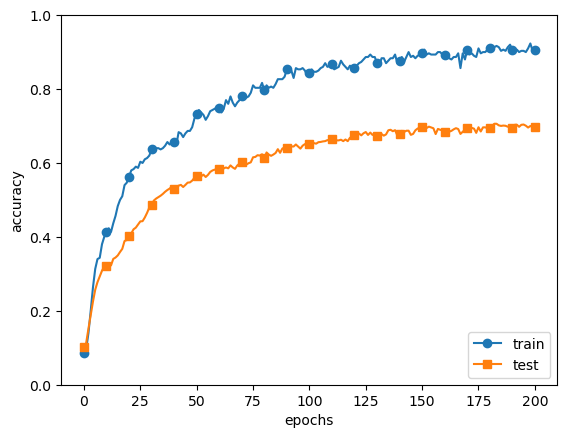

In [104]:
# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

훈련 데이터에 대한 정확도와 시험 데이터에 대한 정확도 차이는 그림 6-20에 비해 줄었음

오버피팅이 억제됨

### 6.4.3 드롭아웃

신경망 모델이 복잡해지면 가중치 감소만으로는 대응하기 어려움

드롭아웃 : 뉴런을 임의로 삭제하면서 학습하는 방법

삭제된 뉴런은 신호를 전달하지 않음

훈련 때에는 데이터를 흘릴 때마다 삭제할 뉴런을 무작위로 선택.

시험 때에는 모든 뉴런에 신호를 전달. 각 뉴런의 출력에 훈련 때 삭제한 비율을 곱하여 출력.

![](./img/10.png)

드롭아웃 구현

In [105]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

훈련 시에는 순전파 때마다 self.mask에 삭제할 뉴런을 False로 표시

self.mask는 x와 형상이 같은 배열을 무작위로 생성하고 그 값이 dropout_ratio보다 큰 원소만 True로 설정

역전파 때의 동작은 ReLU와 같음.

순전파때 신호를 통과시키는 뉴런은 역전파때도 신호를 그대로 통과시키고 순전파 때 통과시키지 않은 뉴런은 역전파 때도 신호를 차단.

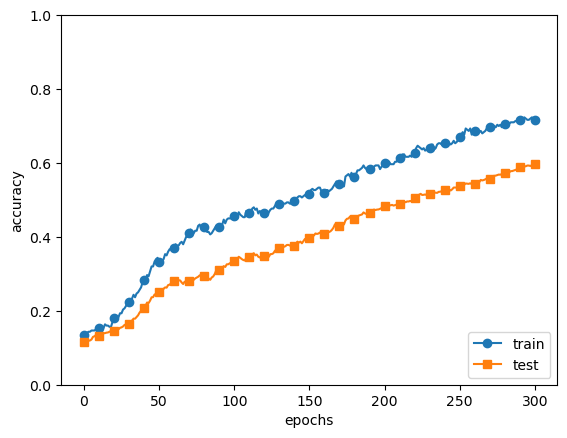

In [106]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=False)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

![](./img/11.png)

드롭아웃을 적용하니 훈련 데이터와 시험 데이터에 대한 정확도 차이가 줄었음

또한 훈련데이터에 대한 정확도가 100%에 도달하지 않음

드롭아웃을 이용하면 표현력을 높이면서 오버피팅을 억제가능

앙상블 학습(ensenble learning)

앙상블 학습은 개별적으로 학습시킨 여러 모델의 출력을 평균내어 추론하는 방식

앙상블 학습은 드롭아웃과 밀접함. 드롭아웃이 학습 때 뉴런을 무작위로 삭제하는 행위를 매번 다른 모델을 학습시키는 것으로 해석

같은 구조의 네트워크를 여러 개 준비하여 따로따로 학습. 여러 개의 출력을 평균내어 답변

드롭아웃은 앙상블 학습과 같은 효과를 (대략) 하나의 네트워크로 구현했다고 볼 수 있음

#### 오버피팅을 억제하는 방법

1. 가중치 감소
2. 드롭아웃(신경망이 복잡할 경우)
3. 데이터를 충분히 확보, 모델의 적정성 유지

## 6.5 적절한 하이퍼파라미터 값 찾기

신경망에는 하이퍼파라미터가 다수 증장한다
  - 각 층의 뉴런수, 배치 크기, 매개변수 갱신 시의 학습률과 가중치 감소 등

이런 값들을 적절히 설정하지 않으면 모델의 성능이 크게 떨어진다

하이퍼파라미터 값을 최대한 효율적으로 탐색하는 방법

### 6.5.1 검증 데이터

하이퍼 파라미터 성능을 평가할 때는 시험 데이터를 사용해서는 안됨

* 하이퍼파라미터 값이 시험 데이터에 오버피팅되기 때문
* 하이퍼파라미터 값의 좋음을 시험데이터로 확인하게 되므로 하이퍼파라미터의 값이 시험데이터에만 적합하도록 조정되어 다른 데이터에는 적응하지 못해 범용 성능이 떨어지는 모델이 될 가능성 존재

검증 데이터(validation data) : 하이퍼파라미터 전용 확인 데이터

훈련 데이터 : 매개변수 학습

시험 데이터 : 신경망의 범용 성능 평가

데이터셋에 따라서는 훈련 데이터, 검증 데이터, 시험 데이터를 미리 분리해둔 것도 있음

MNIST 데이터셋에서 검증 데이터를 얻는 가장 간단한 방법은 훈련 데이터 중 20% 정도를 검증 데이터로 먼저 분리

In [107]:
from dataset.mnist import load_mnist
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

훈련 데이터를 분리하기 전에 입력 데이터와 정답 레이블을 shuffle_dataset으로 뒤섞음

데이터 셋 안의 데이터가 치우쳐 있을지 모르기 때문

### 6.5.2 하이퍼파라미터 최적화

하이퍼파라미터의 최적값이 존재하는 범위를 조금씩 줄여나가는 것이 좋음

대략적인 범위를 우선 설정하고 그 범우에서 무작위로 하이퍼파라미터를 골라낸 후 그 값으로 정확도 평가

신경망의 범위는 대략적으로 지정하는 것이 효과적

0.001~1000과 같이 10의 거듭제곱 단위로 범위를 지정하며 이를 로그스케일로 지정한다고 한다.

하이퍼파라미터 최적화 단계

* 0단계: 하이퍼파라미터 값의 범위를 설정
* 1단계: 설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출
<pre>
무작위로 샘플링해 탐색하는 것이 좋은 결과. 최종 정확도에 미치는 영향력이 하이퍼파라미터마다 다르기 때문
'10의 계승'단위로 범위를 지정. 로그 스케일(log scale)로 지정.
</pre>
* 2단계: 1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 정확도를 평가. (에폭은 작게 설정)
* 3단계: 1단계와 2단계를 특정 횟수(100회 등) 반복하며, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다.

베이즈 최적화(Bayesian optimization)

베이즈 정리(Bayes' theorem)를 중심으로 한 수학 이론을 구사하여 더 엄밀하고 효율적으로 최적화를 수행

### 6.5.3 하이퍼파라미터 최적화 구현하기

하이퍼파라미터 검증은 로그 스케일 범위에서 무작위로 추출해 수행

파이썬코드로는 10 \*\* np.random.uniform(-3,3)처럼 작성.

이 예에서는 가중치 감소 계수를 10<sup>-8</sup>~10<sup>-4</sup>, 학습률을 10<sup>-6</sup>~10<sup>-2</sup> 범위부터 시작.

하이퍼파라미터 무작위 추출코드

In [108]:
weight_decay = 10**np.random.uniform(-8,-4)
lr = 10**np.random.uniform(-6,-2)

가중치 감소 계수 범위를 10<sup>-8</sup> ~ 10<sup>-4</sup>, 학습률의 범위를 10<sup>-6</sup>~10<sup>-2</sup> 실험한 결과

각각 저장된 결과에서 검증데이터 정확도가 가장 좋았던 때의 가중치 감소계수와 학습률 매개변수 값을  Top N을 선정하여 관찰

val acc:0.52 | lr:0.0030757610268956803, weight decay:4.7349192989687613e-08
val acc:0.09 | lr:1.8275719517802413e-06, weight decay:2.2802199361806004e-05
val acc:0.08 | lr:9.728776131001529e-05, weight decay:1.6251520590742772e-08
val acc:0.1 | lr:0.0002234390934041657, weight decay:3.8623794354679577e-07
val acc:0.13 | lr:2.4561242262833185e-05, weight decay:7.540016453455001e-05
val acc:0.34 | lr:0.0021050577414134532, weight decay:7.509913051428848e-05
val acc:0.17 | lr:0.0012331844260247398, weight decay:5.3166259575718036e-05
val acc:0.14 | lr:0.00011606205285626293, weight decay:2.4649277931233803e-08
val acc:0.09 | lr:2.3526920719638046e-06, weight decay:8.23667727561443e-06
val acc:0.15 | lr:0.00010213114586359806, weight decay:5.868984424380902e-06
val acc:0.1 | lr:2.973432235188107e-06, weight decay:3.793209392165825e-07
val acc:0.14 | lr:0.0005698425314958962, weight decay:2.342756230287583e-06
val acc:0.07 | lr:0.00016130666107364727, weight decay:1.1239082499613087e-05
va

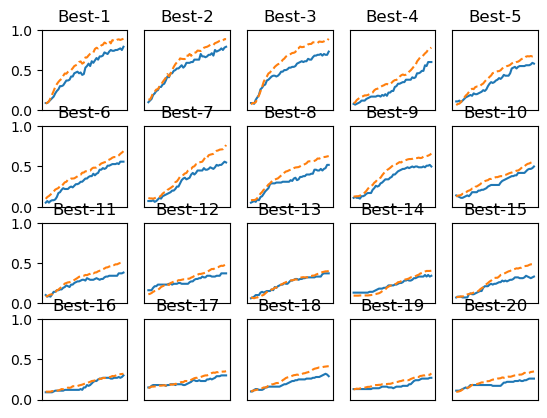

In [109]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/hyperparameter_optimization.py 참고
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

Best-5 정도까지 학습이 순조롭게 진행.

결과로 볼 때 학습률은 0.001 ~ 0.01, 가중치 감소 계수는 10<sup>-8</sup> ~ 10<sup>-6</sup> 정도임을 알 수 있음.

다음은 축소된 범위로 똑같은 작업을 반복.

범위를 좁혀가다가 특정 단계에서 최종 하이퍼파라미터 값을 하나 선택.

## 6.6 정리

**이번 장에서 배운 것**

매개변수 갱신 방벙에는 확률적 경사 하강법(SGD) 외에도 모멘텀, AdaGrad, Adam 등이 있음

가중치 초기값을 정하는 방법은 올바른 학습을 하는데 매우 중요

가중치의 초기값은 Xavier 초기값(Sigmoid, tanh)과 He 초기값(ReLU)이 효과적

배치 정규화(normalization)를 이용하면 학습을 빠르게 진행, 초기값에 영향을 덜 받게 됨

오버피팅을 억제하는 정규화(regularization) 기술로는 가중치 감소와 드롭아웃이 있음

하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 범위를 점차 좁히면서 하는 것이 효과적